In [81]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from skgstat import Variogram, OrdinaryKriging
%set_env SKG_SUPPRESS=true
import warnings
warnings.filterwarnings('ignore')

env: SKG_SUPPRESS=true


In [2]:
sub = xr.open_dataset('../data/netcdfs/banner_lowman_05208_21019-019_21021-007_0006d.nc')

# sub = sub.coarsen(x=4, boundary = 'trim').mean().coarsen(y=4, boundary = 'trim').mean()

for name, values in sub.items():
    if name != 'dem':
        sub[name] = sub[name].where(sub['dem'] != -10000.0)
sub['dem'] = sub['dem'].where(sub['dem'] != -10000.0)

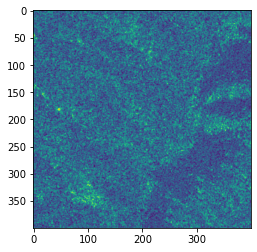

In [30]:
plt.imshow(sub['VV-cor'][100:500,100:500])

In [3]:
coords = sub.attrs['subset_coords']

In [84]:
row_mult = (abs(coords)[0] - abs(coords[2]))/sub['VV-cor'].shape[1]
col_mult = (abs(coords[3])-abs(coords[1]))/sub['VV-cor'].shape[0]

In [5]:
xs = np.arange(coords[0], coords[2], row_mult)

In [6]:
ys = np.arange(coords[1], coords[3], col_mult)

In [7]:
xx, yy = np.meshgrid(xs,ys)

In [64]:
ix = np.random.randint(0,xx.shape[0],10000)
iy = np.random.randint(0,xx.shape[1],10000)

# ix = np.random.randint(900,2400,2500)
# iy = np.random.randint(900,2400,2500)

In [65]:
x_samp = xx[ix,iy]
y_samp = yy[ix,iy]

In [66]:
coords = np.array((x_samp,y_samp)).T

coords = np.array((ix,iy)).T

In [67]:
values = sub['VV-cor'].values[ix, iy]

In [68]:
# values = np.fromiter((sub['VV-cor'][c[0], c[1]] for c in coords), dtype=float)
ix_nan = np.isnan(values)
values = values[~ix_nan]
coords = coords[~ix_nan]

In [70]:
import skgstat as skg
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from skgstat.plotting import backend
# from skgstat.plotting import backend
backend('plotly')

fig = make_subplots(rows=1, cols=1)

V = skg.Variogram(coordinates=coords, values=values, estimator = 'matheron', use_nugget = True, n_lags = 40, maxlag = 1900)

V.plot(axes = fig, show = False, hist =False)

fig.update_layout(
    title = 'VV Semi-Variogram',
    yaxis_title="Semi-Variance",
    xaxis_title = 'Lag (m)',
    width=1000,
    height=500,
    template='seaborn',
    showlegend=False)

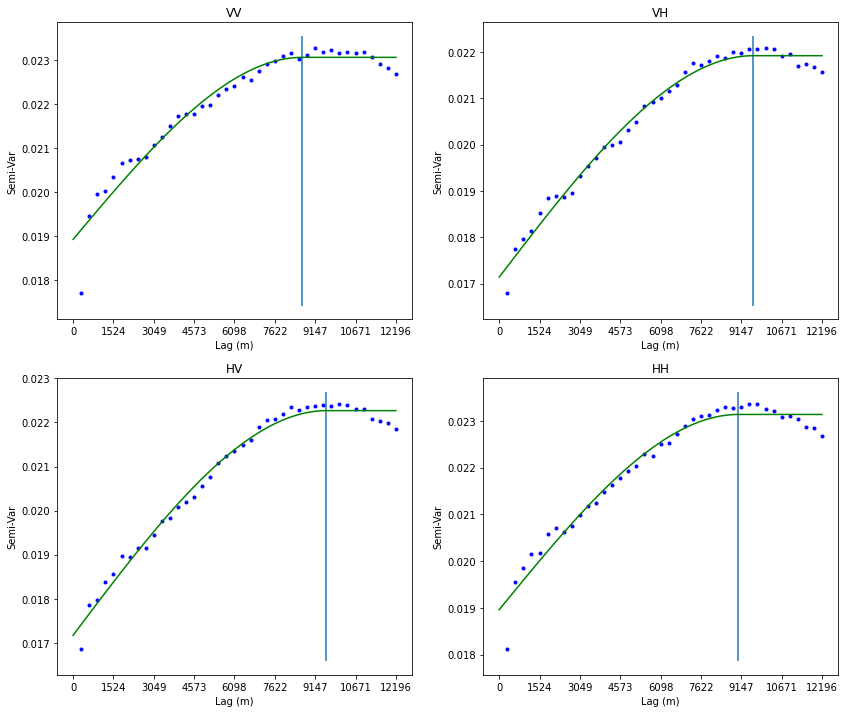

In [135]:
backend('matplotlib')
pols = ['VV','VH','HV','HH']
m_pix = (float(sub.attrs['slt.row_mult'].replace(' m/pixel',''))+float(sub.attrs['slt.col_mult'].replace(' m/pixel','')))/2

fig, ax = plt.subplots(2,2, figsize=(14, 12))

for i, pol in enumerate(pols):
    coords = np.array((x_samp,y_samp)).T
    coords = np.array((ix,iy)).T
    values = sub[f'{pol}-cor'].values[ix, iy]
    ix_nan = np.isnan(values)
    values = values[~ix_nan]
    coords = coords[~ix_nan]
    V = skg.Variogram(coordinates=coords, values=values, estimator = 'matheron', use_nugget = True, n_lags = 40, maxlag = 2000)
    axe = ax.flatten()[i]
    fig = V.plot(axes=axe, hist=False, grid = False)
    
    axe.set_xticklabels(axe.get_xticks())    
    
    labels = [item.get_text() for item in axe.get_xticklabels()]
    labels = [(str(round(int(float(label.replace('−','-'))*m_pix),2))) for label in labels]
    axe.set_xticklabels(labels)
    axe.set_xlabel('Lag (m)')
    axe.set_ylabel('Semi-Var')
    axe.set_title(pol)
    
    range_val = V.describe()['effective_range']
    axe.vlines(range_val, axe.get_ylim()[0] , axe.get_ylim()[1])
plt.savefig('../figures/var-pols.png')
plt.show()

<ipython-input-17-d3d520332294>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


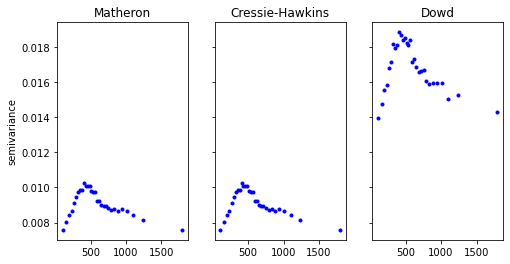

In [17]:
fig, _a = plt.subplots(1, 3, figsize=(8,4), sharey=True)

axes = _a.flatten()

axes[0].plot(V.bins, V.experimental, '.b')

V.estimator = 'cressie'

axes[1].plot(V.bins, V.experimental, '.b')

V.estimator = 'dowd'

axes[2].plot(V.bins, V.experimental, '.b')

axes[0].set_ylabel('semivariance')

axes[0].set_title('Matheron')

axes[1].set_title('Cressie-Hawkins')

axes[2].set_title('Dowd')

fig.show()

In [18]:
from skgstat import models

# set estimator back
V.estimator = 'matheron'

V.model = 'spherical'

xdata = V.bins

ydata = V.experimental

from scipy.optimize import curve_fit

# initial guess - otherwise lm will not find a range
p0 = [np.mean(xdata), np.mean(ydata), 0]

cof, cov =curve_fit(models.spherical, xdata, ydata, p0=p0)

In [19]:
print("range: %.2f   sill: %.f   nugget: %.2f" % (cof[0], cof[1], cof[2]))

range: 314.54   sill: 0   nugget: 0.01


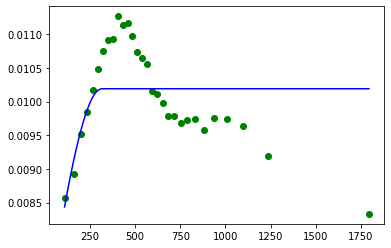

In [20]:
xi =np.linspace(xdata[0], xdata[-1], 100)

yi = [models.spherical(h, *cof) for h in xi]

plt.plot(xdata, ydata, 'og')

plt.plot(xi, yi, '-b');

ValueError: var needs to be > 0.0, got: -0.011030890471924976

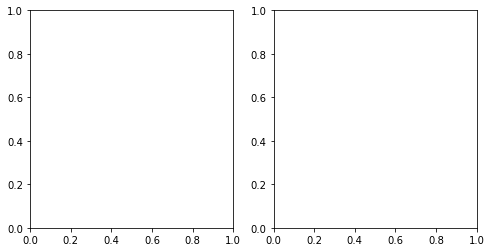

In [183]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

V.model = 'exponential'

krige1 = V.to_gs_krige()

V.model = 'exponential'

krige2 = V.to_gs_krige()

# build a grid
x = y = np.arange(0, 500, 5)

# apply
field1, _ = krige1.structured((x, y))

field2, _ = krige2.structured((x, y))

# use the same bounds
vmin = np.min((field1, field2))

vmax = np.max((field1, field2))

# plot
axes[0].set_title('Spherical')

axes[1].set_title('Exponential')

axes[0].imshow(field1, origin='lower', cmap='terrain_r', vmin=vmin, vmax=vmax)

axes[1].imshow(field2, origin='lower', cmap='terrain_r', vmin=vmin, vmax=vmax)